In [12]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u

In [13]:
dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.2)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 5e-5         # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.2)

In [14]:
t1_val, t2_val = 0.01, 0.1


n1_1 = np.argmin(np.abs(t1 - t1_val))
n2_1 = np.argmin(np.abs(t1 - t2_val))

n1_2 = np.argmin(np.abs(t2 - t1_val))
n2_2 = np.argmin(np.abs(t2 - t2_val))


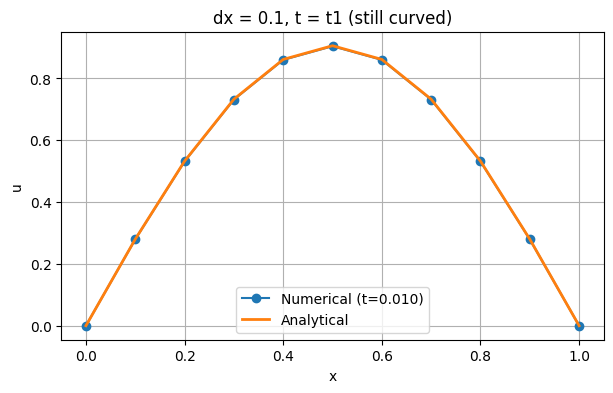

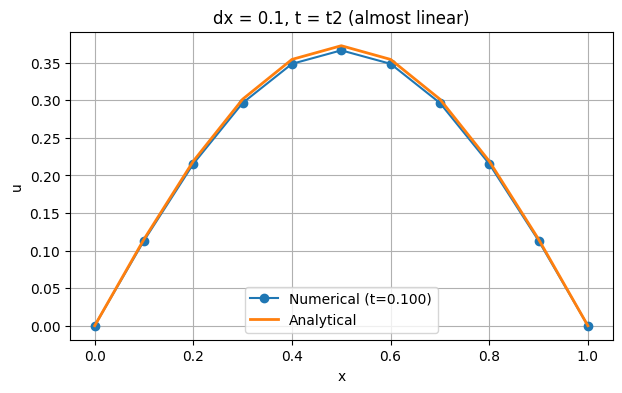

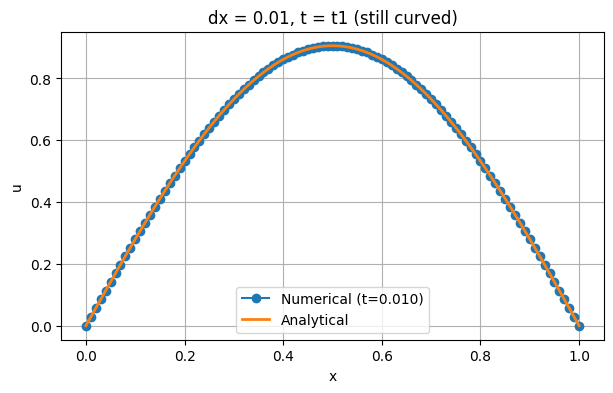

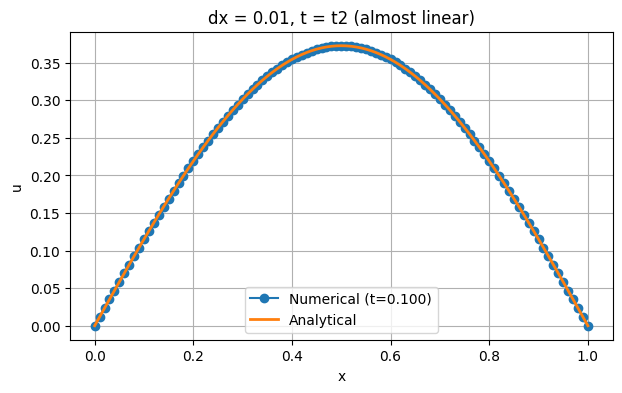

In [15]:
def plot_comparison(x, U, t_grid, n_idx, title):
    t_val = t_grid[n_idx]
    u_num = U[n_idx]
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_num, 'o-', label=f"Numerical (t={t_val:.3f})")
    plt.plot(x, u_exact, '-', label="Analytical", lw=2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison(x1, U1, t1, n1_1, "dx = 0.1, t = t1 (still curved)")
plot_comparison(x1, U1, t1, n2_1, "dx = 0.1, t = t2 (almost linear)")

plot_comparison(x2, U2, t2, n1_2, "dx = 0.01, t = t1 (still curved)")
plot_comparison(x2, U2, t2, n2_2, "dx = 0.01, t = t2 (almost linear)")

In [16]:
NN_model = create_network_model(layers=[6, 7], activation='sigmoid')

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 3000  # Number of training epochs

T_final = 0.5 # Example final time
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)


In [18]:

for epoch in range(epochs):
    # In a simple PINN, we often use a single large batch covering the domain,
    # or resample the collocation points each epoch.
    train_step = make_train_step(NN_model, optimizer, compute_loss)

for epoch in range(epochs):
    current_loss = train_step(X_train)

    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss.numpy():.6e}")


Epoch 50/3000, Loss: 1.009380e+01
Epoch 100/3000, Loss: 8.954042e+00
Epoch 150/3000, Loss: 8.928110e+00
Epoch 200/3000, Loss: 8.893160e+00
Epoch 250/3000, Loss: 8.814891e+00
Epoch 300/3000, Loss: 8.629496e+00
Epoch 350/3000, Loss: 8.267002e+00
Epoch 400/3000, Loss: 7.654591e+00
Epoch 450/3000, Loss: 6.665570e+00
Epoch 500/3000, Loss: 5.264904e+00
Epoch 550/3000, Loss: 3.866241e+00
Epoch 600/3000, Loss: 2.991199e+00
Epoch 650/3000, Loss: 2.366980e+00
Epoch 700/3000, Loss: 1.908896e+00
Epoch 750/3000, Loss: 1.569667e+00
Epoch 800/3000, Loss: 1.288332e+00
Epoch 850/3000, Loss: 1.035087e+00
Epoch 900/3000, Loss: 8.463811e-01
Epoch 950/3000, Loss: 7.065980e-01
Epoch 1000/3000, Loss: 6.015673e-01
Epoch 1050/3000, Loss: 5.191151e-01
Epoch 1100/3000, Loss: 4.514804e-01
Epoch 1150/3000, Loss: 3.942918e-01
Epoch 1200/3000, Loss: 3.454057e-01
Epoch 1250/3000, Loss: 3.037013e-01
Epoch 1300/3000, Loss: 2.682103e-01
Epoch 1350/3000, Loss: 2.379391e-01
Epoch 1400/3000, Loss: 2.120069e-01
Epoch 1450/3

In [19]:
def pinn_solution(model, x, t_value, N_output=1):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    g_val = g_trial_tf(X_eval, model, N_output)
    return g_val.numpy().flatten()


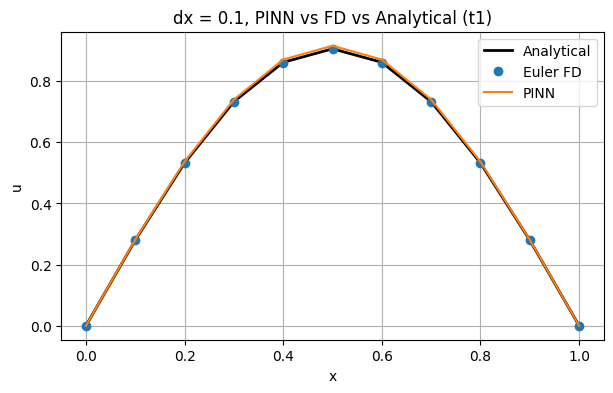

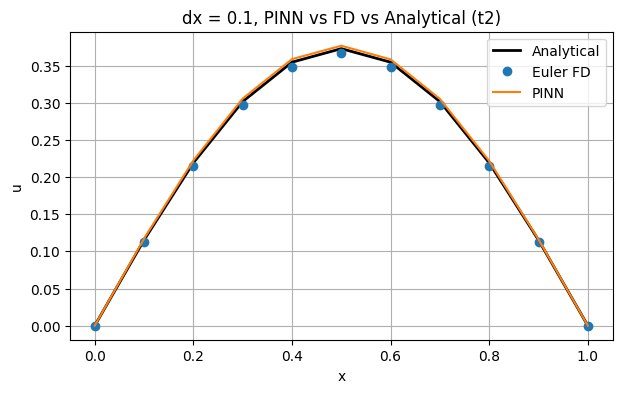

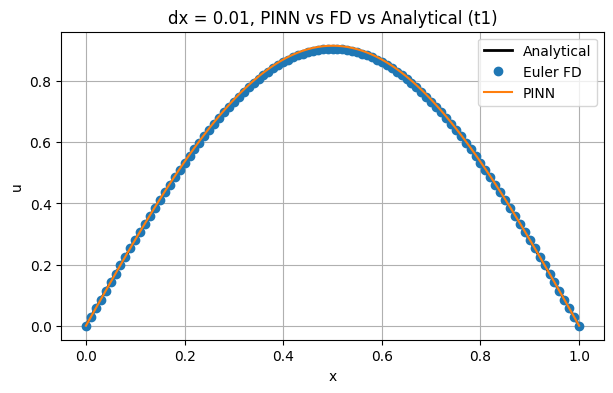

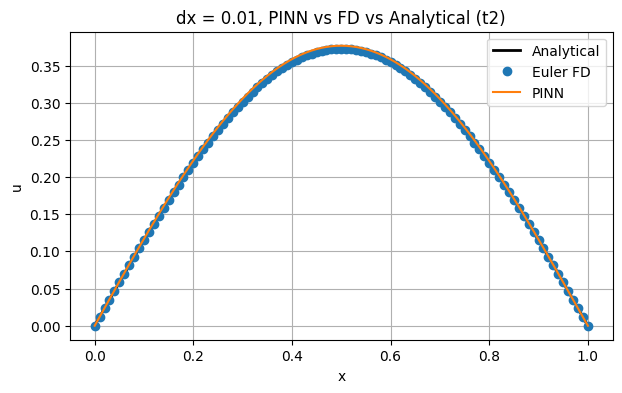

In [20]:
def plot_all(x, t_grid, U, t_target, NN_model, title, N_output=1):
    n_idx = np.argmin(np.abs(t_grid - t_target))
    u_euler = U[n_idx]
    u_exact = analytical_u(x, t_target)
    u_pinn  = pinn_solution(NN_model, x, t_target, N_output)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label="Analytical")
    plt.plot(x, u_euler, 'o', label="Euler FD")
    plt.plot(x, u_pinn, '-', label="PINN")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


t1_val, t2_val = 0.01, 0.10

plot_all(x1, t1, U1, t1_val, NN_model, "dx = 0.1, PINN vs FD vs Analytical (t1)", N_output=N_points)
plot_all(x1, t1, U1, t2_val, NN_model, "dx = 0.1, PINN vs FD vs Analytical (t2)", N_output=N_points)

plot_all(x2, t2, U2, t1_val, NN_model, "dx = 0.01, PINN vs FD vs Analytical (t1)", N_output=N_points)
plot_all(x2, t2, U2, t2_val, NN_model, "dx = 0.01, PINN vs FD vs Analytical (t2)", N_output=N_points)